In [27]:
# 导入库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

np.random.seed(114514)
torch.manual_seed(114514)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


数据概览:
                     p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
date                                                                     
2020-01-01 00:10:00   1008.89      0.71    273.18        -1.33    86.1   
2020-01-01 00:20:00   1008.76      0.75    273.22        -1.44    85.2   
2020-01-01 00:30:00   1008.66      0.73    273.21        -1.48    85.1   
2020-01-01 00:40:00   1008.64      0.37    272.86        -1.64    86.3   
2020-01-01 00:50:00   1008.61      0.33    272.82        -1.50    87.4   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
date                                                                       
2020-01-01 00:10:00          6.43          5.54          0.89       3.42   
2020-01-01 00:20:00          6.45          5.49          0.95       3.39   
2020-01-01 00:30:00          6.44          5.48          0.96       3.39   
2020-01-01 00:40:00          6.27          5.41          0.86       3.35   
2020-01-01 00:50:00

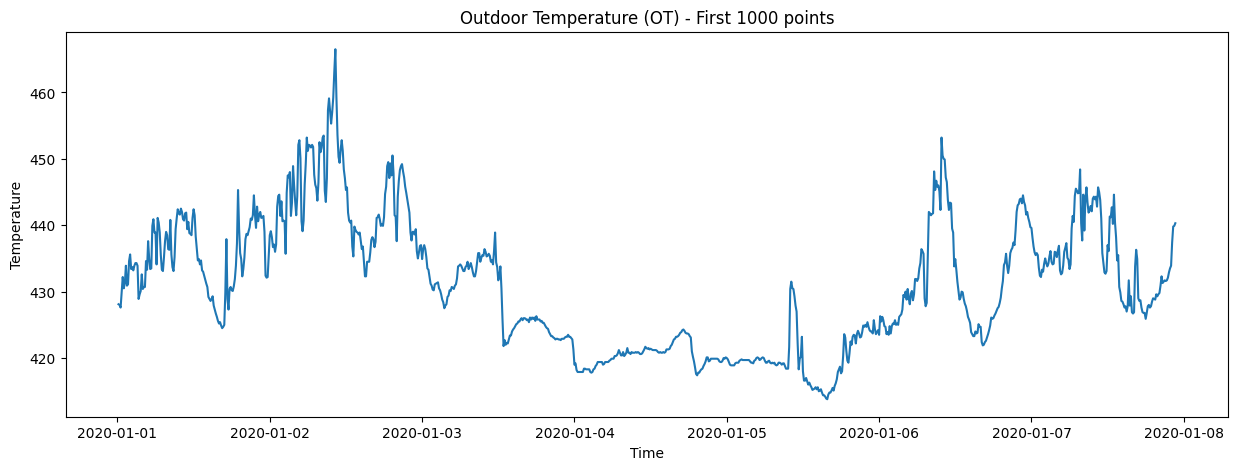

In [28]:
# 数据加载与预处理

# 1 加载数据
data_path = 'DM_2025_Dataset/weather.csv'

# 这玩意是用什么编码的?
df = pd.read_csv(data_path, encoding='latin1')

# 处理时间列：转换为 datetime 设为索引
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 增加时间周期特征
df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)


print("数据概览:")
print(df.head())
print(f"\n数据形状: {df.shape}")

# 2 数据可视化
plt.figure(figsize=(15, 5))
plt.plot(df['OT'][:1000])   #前1000个点
plt.title('Outdoor Temperature (OT) - First 1000 points')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

##数据集的编码格式似乎有点问题, SWDR的单位应该为 W/m², PAR的单位应该是 μmol/m²s


检查所有列的异常值 (-9999):
列 'wv (m/s)' 包含 1 个异常值
列 'max. PAR (ï¿½mol/mï¿½?s)' 包含 10 个异常值
列 'OT' 包含 34 个异常值

将对以下列进行清洗: ['wv (m/s)', 'max. PAR (ï¿½mol/mï¿½?s)', 'OT']
数据清洗完成。
清洗后 OT 列异常值数量: 0


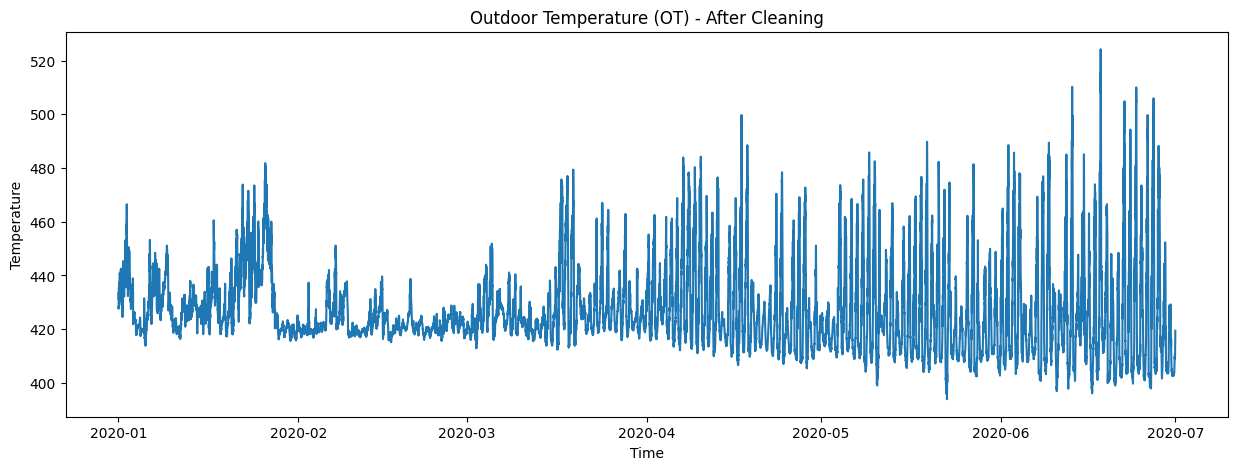

In [29]:
# 数据清洗
# 数据集里存在一些 -9999 的异常值

print("检查所有列的异常值 (-9999):")
abnormal_counts = {}
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        count = len(df[df[col] < -9000]) # 阈值设为 -9000 以捕捉 -9999
        if count > 0:
            abnormal_counts[col] = count
            print(f"列 '{col}' 包含 {count} 个异常值")

# 对所有数值列进行清洗
cols_to_clean = list(abnormal_counts.keys())
if 'OT' not in cols_to_clean and len(df[df['OT'] < -50]) > 0: 
    cols_to_clean.append('OT')

print(f"\n将对以下列进行清洗: {cols_to_clean}")

for col in cols_to_clean:
    # 将异常值替换为 NaN
    threshold = -50 if col == 'OT' else -9000
    df.loc[df[col] < threshold, col] = np.nan
    
    # 使用线性插值填充 NaN
    df[col] = df[col].interpolate(method='linear', limit_direction='both')

print("数据清洗完成。")

# 再次检查 OT 列
n_abnormal_after = len(df[df['OT'] < -50])
print(f"清洗后 OT 列异常值数量: {n_abnormal_after}")

# 可视化清洗后的 OT 数据
plt.figure(figsize=(15, 5))
plt.plot(df['OT']) 
plt.title('Outdoor Temperature (OT) - After Cleaning')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

In [30]:
# 3 特征标准化与数据集划分

# 定义滑动窗口参数
window_size = 144  # 过去 24 小时 
forecast_horizon = 1 # 预测下一时刻
target_col = 'OT'

# 划分训练集和测试集 80% 训练，20% 测试
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

print(f"训练集大小: {len(train_df)}, 测试集大小: {len(test_df)}")

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.values)
test_scaled = scaler.transform(test_df.values)

# 获取 OT 列在标准化后数据中的索引
target_idx = df.columns.get_loc(target_col)

# 4 滑动窗口切分函数
def create_sequences(data, seq_length, target_idx):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length][target_idx] # 预测下一时刻的 OT
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# 创建序列
X_train, y_train = create_sequences(train_scaled, window_size, target_idx)
X_test, y_test = create_sequences(test_scaled, window_size, target_idx)

# 转换为 PyTorch Tensor
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1).to(device)

print(f"训练输入形状: {X_train_tensor.shape}") # (Samples, 12, 21)
print(f"训练目标形状: {y_train_tensor.shape}")

训练集大小: 20960, 测试集大小: 5240
训练输入形状: torch.Size([20816, 144, 25])
训练目标形状: torch.Size([20816, 1])


## 时间序列预测模型设计

**设计思想**：
针对时间序列数据，我们选择 **LSTM** 网络。
*   **原因**：LSTM 是一种特殊的循环神经网络 (RNN)，能够学习长期依赖关系，适合处理像天气这样具有时间相关性的序列数据。与RNN相比，LSTM 能更好地捕捉长期依赖，避免梯度消失问题。
*   **架构**：
    *   **输入层**：接收形状为 `(Batch_Size, Sequence_Length, Input_Dim)` 的数据。`Input_Dim` 为 21。
    *   **LSTM 层**：提取时间特征。
    *   **全连接层 (FC)**：将 LSTM 的输出映射到最终的预测值（即 OT）。

开始训练...
Epoch [5/50], Loss: 0.019512
Epoch [10/50], Loss: 0.018144
Epoch [15/50], Loss: 0.017385
Epoch [20/50], Loss: 0.016673
Epoch [25/50], Loss: 0.015750
Epoch [30/50], Loss: 0.014502
Epoch [35/50], Loss: 0.013345
Epoch [40/50], Loss: 0.012353
Epoch [45/50], Loss: 0.011128
Epoch [50/50], Loss: 0.009849


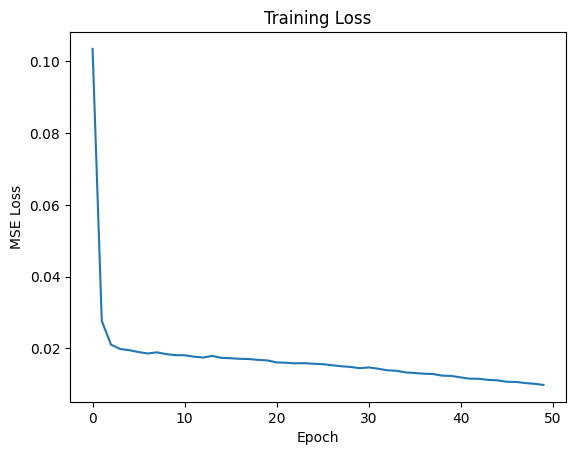

In [31]:
# 5. 模型定义与训练

class WeatherLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(WeatherLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM 层
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # 全连接层
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        
        # 前向传播 LSTM
        # out shape: (batch_size, seq_length, hidden_dim)
        out, _ = self.lstm(x, (h0, c0))
        
        # 取最后一个时间步的输出用于预测
        out = out[:, -1, :]
        
        # 全连接层
        out = self.fc(out)
        return out

# 超参数
input_dim = X_train_tensor.shape[2] # 自动获取特征数量
hidden_dim = 64
output_dim = 1
num_layers = 2
learning_rate = 0.001
num_epochs = 50
batch_size = 64

# 实例化模型
model = WeatherLSTM(input_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 训练循环
train_losses = []

print("开始训练...")
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

# 绘制训练损失
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

模型评估结果 (测试集):
Mean Squared Error (MSE): 24.6378
Mean Absolute Error (MAE): 2.7867
R^2 Score: 0.9523


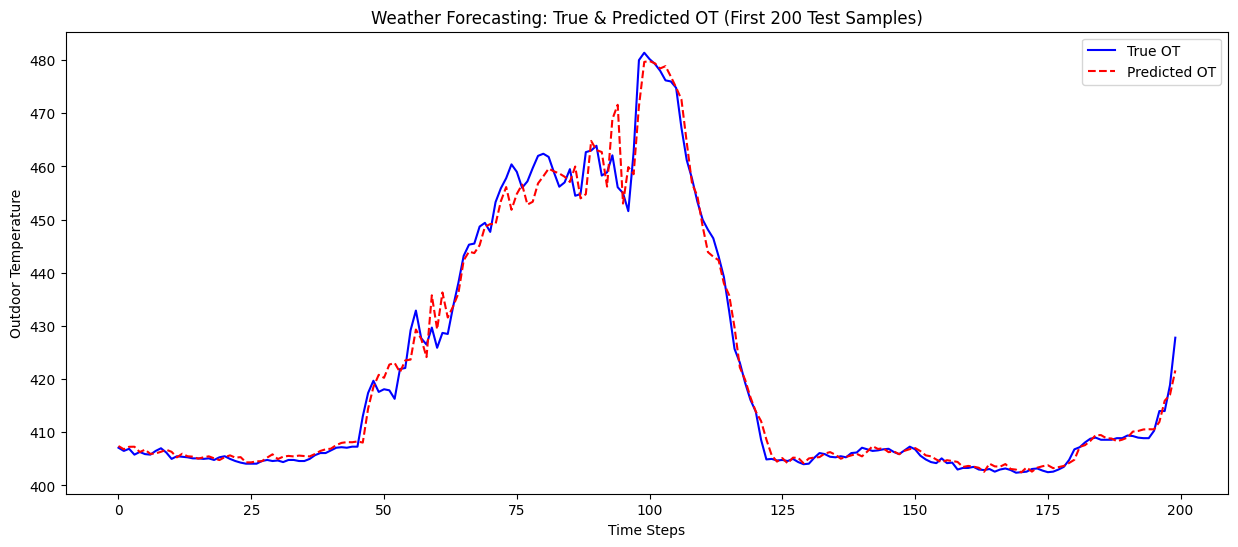

In [32]:
# 6. 模型评估

model.eval()
with torch.no_grad():
    # 在测试集上进行预测
    test_predictions = model(X_test_tensor)
    
    # 将预测结果和真实值转回 CPU numpy
    test_preds_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    # 反归一化
    
    def inverse_transform_target(preds, original_scaler, target_index, n_features):
        # 创建一个形状为 (n_samples, n_features) 的全零矩阵
        dummy = np.zeros((len(preds), n_features))
        # 将预测值填入对应的列
        dummy[:, target_index] = preds.flatten()
        # 反归一化
        inverse_dummy = original_scaler.inverse_transform(dummy)
        # 返回对应的列
        return inverse_dummy[:, target_index]

    # 对预测值和真实值进行反归一化
    real_preds = inverse_transform_target(test_preds_np, scaler, target_idx, input_dim)
    real_y = inverse_transform_target(y_test_np, scaler, target_idx, input_dim)

# 计算评估指标
mse = mean_squared_error(real_y, real_preds)
mae = mean_absolute_error(real_y, real_preds)
r2 = r2_score(real_y, real_preds)

print("模型评估结果 (测试集):")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")

# 可视化预测结果 (展示部分数据)
plt.figure(figsize=(15, 6))
plt.plot(real_y[:200], label='True OT', color='blue')
plt.plot(real_preds[:200], label='Predicted OT', color='red', linestyle='--')
plt.title('Weather Forecasting: True & Predicted OT (First 200 Test Samples)')
plt.xlabel('Time Steps')
plt.ylabel('Outdoor Temperature')
plt.legend()
plt.show()

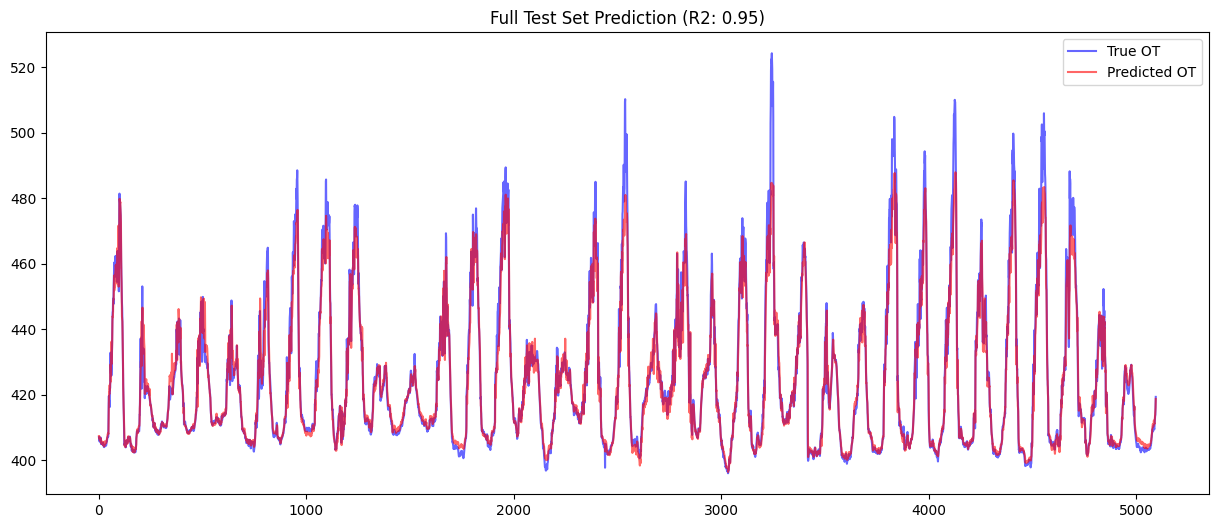

In [33]:
# 可视化整个测试集的预测结果
plt.figure(figsize=(15, 6))
plt.plot(real_y, label='True OT', color='blue', alpha=0.6) # 透明一点看整体效果
plt.plot(real_preds, label='Predicted OT', color='red', alpha=0.6)
plt.title(f'Full Test Set Prediction (R2: {r2:.2f})')
plt.legend()
plt.show()